# Interactive UMAP-explorer

## Imports

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import topo as tp
from scipy.sparse import csr_matrix

import plotly.graph_objects as go
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter
import tifffile
import matplotlib.pyplot as plt
from typing import List, Tuple

# Try GPU UMAP (cuML), fallback to CPU UMAP
try:
    from cuml import UMAP as GPU_UMAP
    use_gpu = True
    print("Using GPU-accelerated UMAP (cuML)")
except ImportError:
    from umap import UMAP as CPU_UMAP
    use_gpu = False
    print("cuML not found, falling back to CPU UMAP")

Using GPU-accelerated UMAP (cuML)


## Config and Data Loading
RUN_NAME should be same used during pre-processing

In [2]:
RUN_NAME = 'Exp06_Site37'
EXP_NAME = 'Exp06_Site37'
BASE_DIR = '/home/nbahou/myimaging/apoDet_refactored'
INPUT_FILE = f"{EXP_NAME}_features.jsonl"
try:
    #df_emb_list = pd.read_csv(INPUT_FILE)
    df_emb_list = pd.read_json(
        INPUT_FILE,
        orient='records',
        lines=True
    )
    print(f"DataFrame loaded successfully. Shape: {df_emb_list.shape}")
except FileNotFoundError:
    print(f"Error: Could not find '{INPUT_FILE}'. Please check the file path.")
    # You would typically stop execution here if the file is critical

# --- 2. Prepare Data for UMAP (Convert to NumPy array 'feats') ---
# Convert the list-of-lists column into the NumPy array UMAP expects.
feats = np.array(df_emb_list['embedding'].tolist())


DataFrame loaded successfully. Shape: (390354, 7)


## Match Embeddings with Annotations if available
Accesses apo_match_csv and annotates all detections after the annotation as 'apo', all other detections are set to 'non-apo'

In [3]:
# --- New Step 1.7: Add Apoptosis Annotation Feature ---

APOPTOSIS_FILE = f"{BASE_DIR}/data/{RUN_NAME}/apo_match_csv/{EXP_NAME}.csv" 
APOPTOSIS_LABEL = 'apo'
NORMAL_LABEL = 'non-apo'

try:
    # 1. Load the apoptosis data
    df_apo = pd.read_csv(APOPTOSIS_FILE)
    print(f"\nLoaded {df_apo.shape[0]} apoptosis annotations.")
    
    # We only need the track_id and the corrected time of apoptosis (correct_t)
    # The 'matching_track' column in your data corresponds to the track_id in df_emb_list
    df_apo = df_apo[['matching_track', 'correct_t']].rename(
        columns={'matching_track': 'track_id', 'correct_t': 't_apoptosis'}
    ).drop_duplicates(subset=['track_id']) # Ensure each track has only one apoptosis time

    # 2. Initialize the new feature column in the main DataFrame
    df_emb_list['phenotype'] = NORMAL_LABEL

    # 3. Merge the apoptosis time into the main DataFrame
    # This adds the t_apoptosis time to every row of the matching track
    df_emb_list = pd.merge(
        df_emb_list, 
        df_apo, 
        on='track_id', 
        how='left'
    )
    
    # 4. Conditionally assign the 'Apoptotic' label
    # A track point is 'Apoptotic' if:
    # a) It belongs to a track that eventually undergoes apoptosis (t_apoptosis is not NaN)
    # b) Its current time ('t') is GREATER THAN or EQUAL TO the time of apoptosis ('t_apoptosis')
    df_emb_list['phenotype'] = np.where(
        df_emb_list['t'] >= df_emb_list['t_apoptosis'],
        APOPTOSIS_LABEL,
        df_emb_list['phenotype']
    )
    
    # 5. Clean up temporary column
    # We keep 't_apoptosis' for debugging, but you could drop it here if needed.
    # df_emb_list = df_emb_list.drop(columns=['t_apoptosis'])

    # Display how many points were labeled
    apo_count = (df_emb_list['phenotype'] == APOPTOSIS_LABEL).sum()
    total_count = df_emb_list.shape[0]
    print(f"Labeled {apo_count} / {total_count} track points as '{APOPTOSIS_LABEL}'.")
    
except FileNotFoundError:
    print(f"Warning: Apoptosis file '{APOPTOSIS_FILE}' not found. Skipping phenotype annotation.")
    if 'phenotype' not in df_emb_list.columns:
         df_emb_list['phenotype'] = NORMAL_LABEL



Loaded 40 apoptosis annotations.
Labeled 387 / 390354 track points as 'apo'.


In [4]:
df_emb_list

track_id    t    y    x  \
0            194  232  714  790   
1           2308  115  736  812   
2           2982  204  572   72   
3           1726   69  334  586   
4            447    9  936  294   
...          ...  ...  ...  ...   
390349      1618   83  296  414   
390350        15   35  676  832   
390351       922  123  184  858   
390352       922  207  190  860   
390353       938  197  124  702   

                                                embedding  \
0       [-5.613732338, -0.9868487716000001, -0.3235633...   
1       [-2.4552211761000002, 0.0558483228, 0.35831421...   
2       [-2.5747191905999998, -0.6678379774000001, -1....   
3       [-4.7323694229, -4.4051270485, 0.8342545033000...   
4       [-5.4849886894, 0.3814259171, -1.4526306391000...   
...                                                   ...   
390349  [1.5921068192, -5.4840259552, 1.7566857338, 3....   
390350  [-1.5060194731, -4.9115228653, -2.0324203968, ...   
390351  [-4.6128573418, -0.0126014696, 1.5435472727000...   
390352  [-1.9490828514, 0.9688180089, 0.7358534336, -5...   
390353  [0.482606709, -0.5701556802000001, -0.12362045...   

                                                     path      filename  \
0       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
1       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
2       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
3       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
4       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
...                                                   ...           ...   
390349  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390350  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390351  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390352  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390353  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   

       phenotype  t_apoptosis  
0        non-apo          NaN  
1        non-apo          NaN  
2        non-apo          NaN  
3        non-apo          NaN  
4        non-apo          NaN  
...          ...          ...  
390349       apo         79.0  
390350       apo          9.0  
390351       apo         62.0  
390352       apo         62.0  
390353       apo        183.0  

[390354 rows x 9 columns]

## Generate UMAP Embeddings

### Display a range of different UMAP settings on the current data

Testing 16 parameter combinations...


[1/16] Testing:
  n_neighbors=15, min_dist=0.0
Running UMAP directly on features...
[2025-11-20 15:31:35.674] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 5.89s
    Spread: X=[66.36], Y=[84.53]

[2/16] Testing:
  n_neighbors=15, min_dist=0.1
Running UMAP directly on features...
[2025-11-20 15:31:41.565] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 5.75s
    Spread: X=[66.93], Y=[83.69]

[3/16] Testing:
  n_neighbors=15, min_dist=0.3
Running UMAP directly on features...
[2025-11-20 15:31:47.339] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 5.77s
    Spread: X=[54.59], Y=[72.53]

[4/16] Testing:
  n_neighbors=15, min_dist=0.5
Running UMAP directly on features...
[202

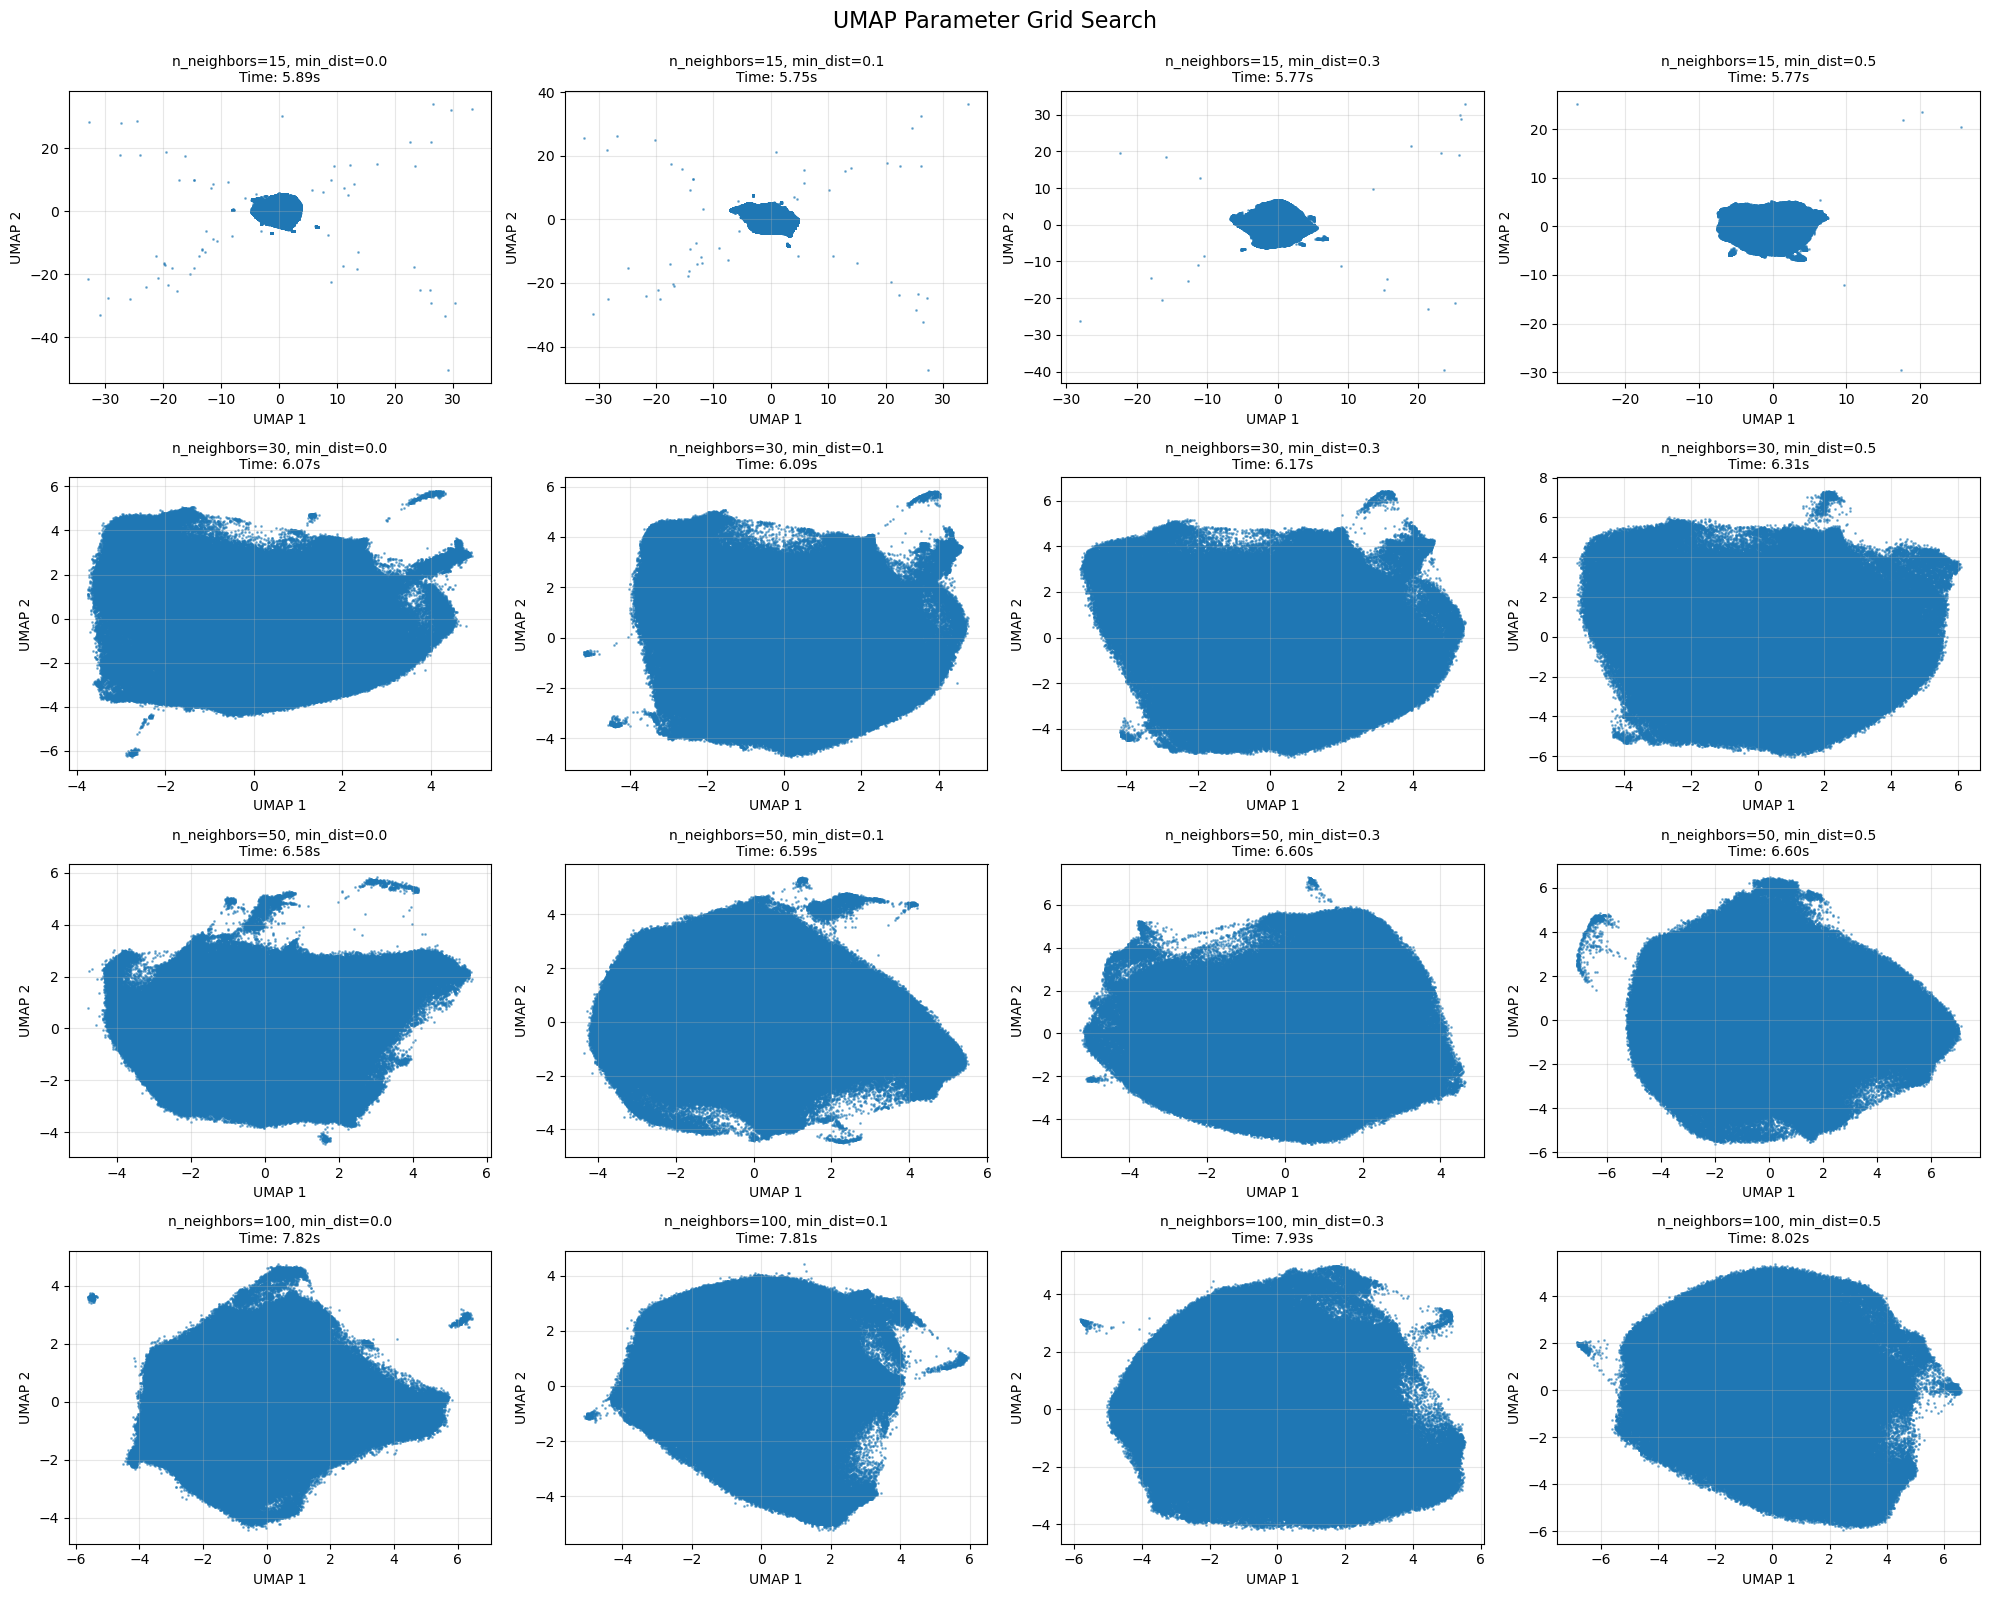

In [10]:
def compute_embedding(feats, use_gpu=True, topometry=False, n_neighbors=50, n_components=2, min_dist=0.1, random_state=42):
    """
    Compute 2D embedding using UMAP, optionally enhanced with TopOMetry.
    
    Parameters
    ----------
    feats : np.ndarray or pd.DataFrame
        Feature matrix (cells x features)
    use_gpu : bool
        Whether to use GPU UMAP (cuml) or CPU UMAP (umap-learn)
    topometry : bool
        Whether to apply TopOMetry graph enhancement first
    n_neighbors : int
        Number of neighbors for UMAP or TopOMetry graph
    n_components : int
        Number of UMAP dimensions
    min_dist : float
        UMAP min_dist parameter
    random_state : int
        Random seed for reproducibility
        
    Returns
    -------
    embedding : np.ndarray
        2D embedding of shape (n_samples, n_components)
    """
    # Optionally apply TopOMetry
    if topometry:
        print("Applying TopOMetry to enhance graph...")
        tg = tp.TopOGraph(
            n_eigs=50,
            base_knn=n_neighbors,
            graph_knn=n_neighbors,
            random_state=random_state,
            n_jobs=-1
        )
        tg.fit(feats)

        tg.transform(feats)
        
        # Extract the first kernel graph (similarity matrix)
        kernel_obj = list(tg.GraphKernelDict.values())[0]

        # Convert to distance: D = 1 - normalized_K
        K = kernel_obj.K.astype(float)
        # normalize to [0,1] if not already
        K = K / K.max()
        
        D = K.copy()                  # copy sparse matrix
        D.data = 1.0 - D.data         # subtract only the non-zero entries
        D.setdiag(0)
        D.eliminate_zeros() # Good practice to clean up
        D = D.toarray()
        
        data_for_umap = D
        metric = "precomputed"
        UMAP_Class = CPU_UMAP
    else:
        print("Running UMAP directly on features...")
        data_for_umap = feats
        metric = "cosine"
        UMAP_Class = GPU_UMAP if use_gpu else CPU_UMAP
    
    
    # Instantiate UMAP reducer
    reducer = UMAP_Class(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )

    

    # Fit and transform
    embedding = reducer.fit_transform(data_for_umap)
    print(f"Computed UMAP embedding of shape: {embedding.shape}")
    
    return embedding

import numpy as np
import pandas as pd
from itertools import product
import time
import matplotlib.pyplot as plt

# Define parameter grid
param_grid = {
    'n_neighbors': [15, 30, 50, 100],
    'min_dist': [0.0, 0.1, 0.3, 0.5]
}

# Generate all combinations
param_combinations = list(product(
    param_grid['n_neighbors'],
    param_grid['min_dist']
))

print(f"Testing {len(param_combinations)} parameter combinations...\n")
print("=" * 80)

# Store results and embeddings
results = []
embeddings = []

# Test each combination
for i, (n_neighbors, min_dist) in enumerate(param_combinations, 1):
    print(f"\n[{i}/{len(param_combinations)}] Testing:")
    print(f"  n_neighbors={n_neighbors}, min_dist={min_dist}")
    
    start_time = time.time()
    
    try:
        # Compute embedding
        embedding = compute_embedding(
            feats,
            use_gpu=use_gpu,
            topometry=False,
            n_neighbors=n_neighbors,
            n_components=2,
            min_dist=min_dist,
            random_state=42
        )
        
        elapsed_time = time.time() - start_time
        
        # Calculate some basic metrics about the embedding
        embedding_std = np.std(embedding, axis=0)
        embedding_range = np.ptp(embedding, axis=0)  # peak-to-peak (max - min)
        
        results.append({
            'n_neighbors': n_neighbors,
            'min_dist': min_dist,
            'time_seconds': elapsed_time,
            'std_x': embedding_std[0],
            'std_y': embedding_std[1],
            'range_x': embedding_range[0],
            'range_y': embedding_range[1],
            'status': 'Success'
        })
        
        embeddings.append(embedding)
        
        print(f"  ✓ Completed in {elapsed_time:.2f}s")
        print(f"    Spread: X=[{embedding_range[0]:.2f}], Y=[{embedding_range[1]:.2f}]")
        
    except Exception as e:
        elapsed_time = time.time() - start_time
        results.append({
            'n_neighbors': n_neighbors,
            'min_dist': min_dist,
            'time_seconds': elapsed_time,
            'std_x': np.nan,
            'std_y': np.nan,
            'range_x': np.nan,
            'range_y': np.nan,
            'status': f'Failed: {str(e)}'
        })
        embeddings.append(None)
        print(f"  ✗ Failed: {str(e)}")

print("\n" + "=" * 80)
print("\nGRID SEARCH RESULTS:")
print("=" * 80)

# Convert to DataFrame for nice display
results_df = pd.DataFrame(results)

# Sort by time (fastest first) among successful runs
results_df_success = results_df[results_df['status'] == 'Success'].sort_values('time_seconds')
results_df_failed = results_df[results_df['status'] != 'Success']

print("\n✓ SUCCESSFUL RUNS (sorted by speed):")
print(results_df_success.to_string(index=False))

if len(results_df_failed) > 0:
    print("\n✗ FAILED RUNS:")
    print(results_df_failed.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY:")
print(f"  Total runs: {len(results)}")
print(f"  Successful: {len(results_df_success)}")
print(f"  Failed: {len(results_df_failed)}")
if len(results_df_success) > 0:
    print(f"  Fastest run: {results_df_success.iloc[0]['time_seconds']:.2f}s")
    print(f"  Slowest run: {results_df_success.iloc[-1]['time_seconds']:.2f}s")
    print(f"  Average time: {results_df_success['time_seconds'].mean():.2f}s")

# Plot all embeddings in a grid
print("\n" + "=" * 80)
print("VISUALIZING EMBEDDINGS...")
print("=" * 80)

n_rows = len(param_grid['n_neighbors'])
n_cols = len(param_grid['min_dist'])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
fig.suptitle('UMAP Parameter Grid Search', fontsize=16, y=0.995)

for idx, ((n_neighbors, min_dist), embedding, result) in enumerate(zip(param_combinations, embeddings, results)):
    row = idx // n_cols
    col = idx % n_cols
    
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    if embedding is not None:
        # Plot the embedding
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], 
                           s=1, alpha=0.5, rasterized=True)
        
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}\n"
                    f"Time: {result['time_seconds']:.2f}s", 
                    fontsize=10)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'FAILED', 
               ha='center', va='center', fontsize=20, color='red',
               transform=ax.transAxes)
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}\n"
                    f"Status: {result['status']}", 
                    fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

### Calculate actual UMAP embeddings
Choose n_neighbors and min_dist from the plot above!

In [15]:
embedding = compute_embedding(feats, n_neighbors=50, min_dist=0.5, use_gpu=use_gpu, topometry=False)

Running UMAP directly on features...
[2025-11-20 15:39:55.746] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)


In [16]:
# 'df_emb_list' now only contains metadata (t, x, y, track_id)
df_emb_list['umap_1'] = embedding[:, 0]
df_emb_list['umap_2'] = embedding[:, 1]

print("\nUMAP coordinates added to df_emb_list.")


UMAP coordinates added to df_emb_list.


## Sample subset
Currently not working

In [17]:
# --- Configuration ---
SAMPLE_MODE = "sample_per_track"   # options: "sample_tracks" or "sample_per_track"
N_TRACKS_TO_SAMPLE = 200        # used only in "sample_tracks" mode
N_SAMPLES_PER_TRACK = 50        # used only in "sample_per_track" mode

# --- Subsetting Logic ---
unique_track_ids = df_emb_list['track_id'].unique()

if SAMPLE_MODE == "sample_tracks":
    # --- Mode 1: sample a subset of tracks ---
    n_actual_sample = min(N_TRACKS_TO_SAMPLE, len(unique_track_ids))
    sampled_ids = pd.Series(unique_track_ids).sample(
        n=n_actual_sample,
        random_state=42
    ).tolist()
    df_subset = df_emb_list[df_emb_list['track_id'].isin(sampled_ids)].copy()

elif SAMPLE_MODE == "sample_per_track":
    # --- Mode 2: sample n examples per track ---
    df_subset = (
        df_emb_list
        .groupby("track_id", group_keys=False)
        .apply(lambda g: g.sample(n=min(N_SAMPLES_PER_TRACK, len(g)), random_state=42))
        .reset_index(drop=True)
    )

else:
    raise ValueError(f"Invalid SAMPLE_MODE '{SAMPLE_MODE}'. Choose 'sample_tracks' or 'sample_per_track'.")

# --- Summary ---
print(f"Sampling mode: {SAMPLE_MODE}")
print(f"Original DataFrame Size: {df_emb_list.shape[0]} rows")
print(f"Subset DataFrame Size: {df_subset.shape[0]} rows")
print(f"Total Unique Tracks in Subset: {df_subset['track_id'].nunique()}")


Sampling mode: sample_per_track
Original DataFrame Size: 390354 rows
Subset DataFrame Size: 100923 rows
Total Unique Tracks in Subset: 2326


/tmp/ipykernel_1523848/189899440.py:23: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## Interactive Viewer

In [18]:
import plotly.graph_objects as go
import plotly.colors
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import os
from typing import List, Tuple

# ============================================================================
# CONFIGURATION & DATA PREPARATION
# ============================================================================

image_paths = df_emb_list['path'].to_list()
class_labels = df_emb_list['phenotype'].to_list()
embedding = df_emb_list[['umap_1', 'umap_2']].values

# Prepare track ID options
all_track_ids = sorted(df_emb_list['track_id'].unique().astype(int))

# Initialize nearest neighbors model
nbrs = NearestNeighbors(n_neighbors=20, algorithm='kd_tree').fit(embedding)

# Add new column for manual labels
if 'label_manual' not in df_emb_list.columns:
    df_emb_list['label_manual'] = None

# Track current filtered dataframe and selected tracks
filtered_df_emb_list = df_emb_list.copy()
filtered_embedding = embedding.copy()
selected_tracks = []  # Can select multiple tracks for comparison
annotations = []  # Store user annotations

point_opacity = 0.7

print(f"Total dataset size: {len(df_emb_list):,} cells")
print(f"Unique phenotypes: {df_emb_list['phenotype'].nunique()}")
print(f"Unique tracks: {df_emb_list['track_id'].nunique()}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_nearest(x0: float, y0: float, k: int = 20) -> List[Tuple]:
    """Find k nearest neighbors to clicked point."""
    distances, indices = nbrs.kneighbors([[x0, y0]], n_neighbors=k)
    idx_list = indices[0]
    
    results = []
    for j, i in enumerate(idx_list):
        row = filtered_df_emb_list.iloc[i]
        results.append((
            row['path'],
            filtered_embedding[i],
            distances[0][j],
            row['phenotype']
        ))
    return results


def compute_density_contours(df: pd.DataFrame, n_levels: int = 5, margin: float = 0.05):
    if len(df) < 10:
        return None

    x = df['umap_1'].values
    y = df['umap_2'].values

    x_range = x.max() - x.min()
    y_range = y.max() - y.min()
    x_min, x_max = x.min() - margin * x_range, x.max() + margin * x_range
    y_min, y_max = y.min() - margin * y_range, y.max() + margin * y_range

    H, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[x_min, x_max], [y_min, y_max]])
    H = gaussian_filter(H, sigma=1.5)
    levels = np.linspace(H.min(), H.max(), n_levels + 2)[1:-1]

    return H.T, xedges, yedges, levels


def compute_density_per_phenotype(df, n_levels=5, margin: float = 0.05):
    contours = {}
    for pheno in df['phenotype'].unique():
        sub = df[df['phenotype'] == pheno]
        if len(sub) < 10:
            continue

        x = sub['umap_1'].values
        y = sub['umap_2'].values

        # ---- SAME MARGIN ----
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        x_min, x_max = x.min() - margin * x_range, x.max() + margin * x_range
        y_min, y_max = y.min() - margin * y_range, y.max() + margin * y_range

        H, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[x_min, x_max], [y_min, y_max]])
        H = gaussian_filter(H, sigma=1.5)
        levels = np.linspace(H.min(), H.max(), n_levels + 2)[1:-1]
        contours[pheno] = (H.T, xedges, yedges, levels)
    return contours


def compute_convex_hulls(df: pd.DataFrame):
    """Compute convex hulls for each phenotype."""
    hulls = {}
    for phenotype in df['phenotype'].unique():
        subset = df[df['phenotype'] == phenotype]
        if len(subset) >= 3:
            points = subset[['umap_1', 'umap_2']].values
            try:
                hull = ConvexHull(points)
                hulls[phenotype] = points[hull.vertices]
            except:
                pass
    return hulls


def show_neighbor_channels_grid(
    neighbors: List[Tuple], 
    k: int = 5, 
    figsize: Tuple[int, int] = (10, 10),
    neighbor_names: List[str] = None
):
    """Display grid of multi-channel cell images for nearest neighbors."""
    k = min(k, len(neighbors))
    if k == 0:
        print("Neighbor list is empty.")
        return

    plt.close('all')
    
    fig, axes = plt.subplots(k, 5, figsize=figsize)
    if k == 1:
        axes = np.array([axes])

    for i in range(k):
        path = neighbors[i][0]
        dist = neighbors[i][2]
        classification = neighbors[i][3]

        try:
            img = tifffile.imread(path)
        except FileNotFoundError:
            print(f"Error: File not found at {path}")
            for j in range(5):
                ax = axes[i, j]
                ax.imshow(np.zeros((128, 128)), cmap="gray")
                ax.axis('off')
                if j == 2:
                    ax.text(64, 64, 'File Not Found', color='white', 
                           ha='center', va='center')
            continue

        if img.ndim == 3 and img.shape[0] == 5:
            img = img.transpose(1, 2, 0)

        if img.shape[-1] != 5:
            raise ValueError(f"Image at {path} does not have 5 channels in last dimension.")

        for j in range(5):
            ax = axes[i, j]
            channel_image = img[..., j]
            ax.imshow(channel_image, cmap='gray', aspect='equal')
            ax.axis('off')

        if i == 0:
            for j in range(5):
                axes[i, j].set_title(f"Channel {j+1}", fontsize=10)

        if neighbor_names and i < len(neighbor_names):
            row_label_name = neighbor_names[i]
        else:
            row_label_name = f"Neighbor {i+1}"

        full_row_label = f"{row_label_name}\nClass: {classification}\nd={dist:.2f}"
        axes[i, 0].text(-0.3, 0.5, full_row_label, 
                       transform=axes[i, 0].transAxes,
                       fontsize=9, ha='right', va='center')

    plt.tight_layout(pad=0.5, h_pad=1.0)
    plt.show()


def update_neighbors_model(df: pd.DataFrame):
    """Rebuild nearest neighbors model when data is filtered."""
    global nbrs, filtered_embedding
    
    if len(df) == 0:
        print("Warning: Filtered dataset is empty!")
        return
    
    filtered_embedding = df[['umap_1', 'umap_2']].values
    k_max = min(20, len(df))
    nbrs = NearestNeighbors(n_neighbors=k_max, algorithm='kd_tree').fit(filtered_embedding)
    print(f"Nearest neighbors model updated with {len(df):,} points")


def get_track_color(idx, n_tracks):
    """Get a distinct color for each track."""
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
    return colors[idx % len(colors)]


def update_plot(df_to_plot: pd.DataFrame):
    """Clear and rebuild plot traces based on filtered DataFrame."""
    global fig
    
    # Clear existing traces and annotations
    fig.data = []
    fig.layout.annotations = []
    
    if len(df_to_plot) == 0:
        info_text.value = "⚠️ No data matches current filters"
        return
    
    # Determine filtering mode
    filter_to_tracks = track_filter_checkbox.value and len(selected_tracks) > 0
    
    # Prepare data based on filter mode
    if filter_to_tracks:
        # Only show selected tracks
        df_display = df_to_plot[df_to_plot['track_id'].isin(selected_tracks)].copy()
        df_background = pd.DataFrame()
    else:
        # Show all data, but highlight selected tracks
        df_display = df_to_plot.copy()
        df_background = df_to_plot[~df_to_plot['track_id'].isin(selected_tracks)] if len(selected_tracks) > 0 else df_to_plot
    
    # Add background points (dimmed if tracks are selected)
    if len(df_background) > 0 and len(selected_tracks) > 0:
        df_bg = df_background.copy()

        # ---- NEW: Filter to labeled only? ----
        if show_only_labeled_checkbox.value:
            df_bg = df_bg[df_bg['label_manual'].notna()]

        

        # ---- Sort non-apo on top (only for phenotype) ----
        if not use_manual_labels_checkbox.value:
            df_bg = df_bg.sort_values(
                by='phenotype',
                key=lambda x: x == 'apo'
            )

        color_col = 'label_manual' if use_manual_labels_checkbox.value else 'phenotype'
        labels = df_bg[color_col].fillna('unlabeled')

        # ---- Color map ----
        unique_labels = labels.unique()
        colors = plotly.colors.qualitative.Plotly
        color_map = {lbl: colors[i % len(colors)] for i, lbl in enumerate(unique_labels)}
        color_map['unlabeled'] = 'lightgray'
        point_colors = [color_map[lbl] for lbl in labels]

        # ---- Customdata & hover ----
        has_t = 't' in df_bg.columns
        custom_cols = ['track_id', 't', color_col] if has_t else ['track_id', color_col]
        customdata = df_bg[custom_cols].values
        hover_idx = 2 if has_t else 1
    
        scatter = go.Scattergl(
            x=df_bg['umap_1'],
            y=df_bg['umap_2'],
            mode='markers',
            name='Background',
            marker=dict(size=4, opacity=point_opacity * 0.35, color=point_colors),
            text=df_bg['path'],
            customdata=customdata,
            ids=df_bg.index,
            hovertemplate=(
                f'<b>{color_col.capitalize()}:</b> %{{customdata[{hover_idx}]}}<br>'
                '<b>UMAP 1:</b> %{x:.2f}<br>'
                '<b>UMAP 2:</b> %{y:.2f}<br>'
                + ('<b>Track:</b> %{customdata[0]}<br><b>Frame:</b> %{customdata[1]}<br>'
                   if has_t else '<b>Track:</b> %{customdata[0]}<br>') +
                '<extra></extra>'
            ),
            showlegend=False
        )
        fig.add_trace(scatter)
    
        # ---- Legend (only show real labels) ----
        for lbl in unique_labels:
            if lbl == 'unlabeled' and not use_manual_labels_checkbox.value:
                continue
            fig.add_trace(go.Scattergl(
                x=[None], y=[None],
                mode='markers',
                marker=dict(color=color_map[lbl], size=10),
                name=str(lbl),
                showlegend=True
            ))
    
    # Add selected tracks or all data if no tracks selected
    if len(selected_tracks) > 0:
        # Show each selected track with its own color
        for idx, track_id in enumerate(selected_tracks):
            track_data = df_display[df_display['track_id'] == track_id].copy()
            
            if len(track_data) == 0:
                continue
            
            track_color = get_track_color(idx, len(selected_tracks))
            
            # Add scatter points
            scatter = go.Scattergl(
                x=track_data['umap_1'],
                y=track_data['umap_2'],
                mode='markers',
                name=f'Track {track_id}',
                marker=dict(size=8, opacity=0.9, color=track_color, line=dict(width=1, color='white')),
                text=track_data['path'],
                customdata=track_data[['track_id', 't', 'phenotype']].values if 't' in track_data.columns else None,
                ids=track_data.index,
                hovertemplate=(
                    '<b>Track:</b> %{customdata[0]}<br>'
                    + ('<b>Frame:</b> %{customdata[1]}<br>' if 't' in track_data.columns else '') +
                    ('<b>Phenotype:</b> %{customdata[2]}<br>' if 't' in track_data.columns else '') +
                    '<b>UMAP 1:</b> %{x:.2f}<br>'
                    '<b>UMAP 2:</b> %{y:.2f}<br>'
                    '<extra></extra>'
                )
            )
            fig.add_trace(scatter)
            
            # Add trajectory if requested
            if track_connect_checkbox.value and 't' in track_data.columns and len(track_data) > 1:
                track_data = track_data.sort_values('t')
                
                # Choose coloring mode
                if trajectory_color_mode.value == 'Time':
                    marker_colors = track_data['t'].values
                    colorscale = 'Viridis'
                    colorbar_title = "Frame"
                elif trajectory_color_mode.value == 'Phenotype':
                    discrete_colors = ['#1f77b4', '#ff7f0e'] 
                    unique_phenotypes = track_data['phenotype'].unique()
                    if len(unique_phenotypes) <= len(discrete_colors):
                        phenotype_map = {p: discrete_colors[i] for i, p in enumerate(unique_phenotypes)}
                        marker_colors = track_data['phenotype'].map(phenotype_map).values
                        colorscale = None 
                    else:
                        phenotype_map = {p: i for i, p in enumerate(unique_phenotypes)}
                        marker_colors = track_data['phenotype'].map(phenotype_map).values
                        colorscale = 'Rainbow'
                    colorbar_title = "Phenotype"
                else:  # Track color
                    marker_colors = track_color
                    colorscale = None
                    colorbar_title = None
                
                line_trace = go.Scattergl(
                    x=track_data['umap_1'],
                    y=track_data['umap_2'],
                    mode='lines+markers',
                    line=dict(color=track_color, width=2),
                    marker=dict(
                        size=10,
                        color=marker_colors,
                        colorscale=colorscale,
                        showscale=(colorscale is not None and idx == 0),
                        colorbar=dict(title=colorbar_title, x=1.15) if colorscale else None,
                        line=dict(width=1, color='white')
                    ),
                    customdata=track_data[['t', 'phenotype']].values if 't' in track_data.columns else None,
                    ids=track_data.index,
                    hovertemplate=(
                        '<b>Track:</b> ' + str(track_id) + '<br>'
                        '<b>Frame:</b> %{customdata[0]}<br>'
                        '<b>Phenotype:</b> %{customdata[1]}<br>'
                        '<b>UMAP 1:</b> %{x:.2f}<br>'
                        '<b>UMAP 2:</b> %{y:.2f}<br>'
                        '<extra></extra>'
                    ),
                    name=f'Trajectory {track_id}',
                    showlegend=False
                )
                fig.add_trace(line_trace)
    
    # If no tracks selected, show regular phenotype view as a single trace
    elif len(selected_tracks) == 0:
        df_display = df_to_plot.copy()

        # ---- NEW: Show only labeled cells? ----
        if show_only_labeled_checkbox.value:
            df_display = df_display[df_display['label_manual'].notna()]

        

        # Sort so non-apo on top (only if using phenotype)
        if not use_manual_labels_checkbox.value:
            df_display = df_display.sort_values(
                by='phenotype',
                key=lambda x: x == 'apo'
            )

        color_col = 'label_manual' if use_manual_labels_checkbox.value else 'phenotype'
        labels = df_display[color_col].fillna('unlabeled')  # NA → gray

        # Build color map
        unique_labels = labels.unique()
        colors = plotly.colors.qualitative.Plotly
        color_map = {lbl: colors[i % len(colors)] for i, lbl in enumerate(unique_labels)}
        color_map['unlabeled'] = 'lightgray'

        point_colors = [color_map[lbl] for lbl in labels]

        has_t = 't' in df_display.columns
        custom_cols = ['track_id', 't', color_col] if has_t else ['track_id', color_col]
        customdata = df_display[custom_cols].values
        hover_idx = 2 if has_t else 1

        
        scatter = go.Scattergl(
            x=df_display['umap_1'],
            y=df_display['umap_2'],
            mode='markers',
            marker=dict(size=6, opacity=point_opacity, color=point_colors),
            text=df_display['path'],
            customdata=customdata,
            ids=df_display.index,
            hovertemplate=(
                f'<b>{color_col.capitalize()}:</b> %{{customdata[{hover_idx}]}}<br>'
                '<b>UMAP 1:</b> %{x:.2f}<br>'
                '<b>UMAP 2:</b> %{y:.2f}<br>'
                + ('<b>Track:</b> %{customdata[0]}<br><b>Frame:</b> %{customdata[1]}<br>'
                   if has_t else '<b>Track:</b> %{customdata[0]}<br>') +
                '<extra></extra>'
            ),
            name='All cells',
            showlegend=False
        )
        fig.add_trace(scatter)
    
        # Legend
        for lbl in unique_labels:
            if lbl == 'unlabeled' and not use_manual_labels_checkbox.value:
                continue  # hide gray from legend in phenotype mode
            fig.add_trace(go.Scattergl(
                x=[None], y=[None],
                mode='markers',
                marker=dict(color=color_map[lbl], size=10),
                name=str(lbl),
                showlegend=True
            ))
    
    # Add density contours if requested
    if show_density_checkbox.value:
        # ---- 1. Per-phenotype contours (optional) ----
        if per_phenotype_density_checkbox.value:
            per_pheno = compute_density_per_phenotype(df_to_plot)
            # colour map is the same one we used for the points
            # (it is built a few lines above in the background / main block)
            # → reuse the variable `color_map` that already exists there
            for pheno, (H, xedges, yedges, levels) in per_pheno.items():
                fig.add_trace(go.Contour(
                    z=H,
                    x=xedges[:-1],
                    y=yedges[:-1],
                    contours=dict(
                        start=levels[0],
                        end=levels[-1],
                        size=(levels[-1] - levels[0]) / len(levels),
                        coloring='none'
                    ),
                    line=dict(width=2.5, color=color_map.get(pheno, 'gray'), dash='dot'),
                    name=f'{pheno} density',
                    showlegend=False,
                    hoverinfo='skip'
                ))
    
        # ---- 2. Global contour (fallback) ----
        else:
            result = compute_density_contours(df_to_plot)
            if result:
                H, xedges, yedges, levels = result
                fig.add_trace(go.Contour(
                    z=H,
                    x=xedges[:-1],
                    y=yedges[:-1],
                    contours=dict(
                        start=levels[0],
                        end=levels[-1],
                        size=(levels[-1] - levels[0]) / len(levels),
                        coloring='none'
                    ),
                    line=dict(width=2, color='rgba(0,0,0,0.3)'),
                    showscale=False,
                    name='Density',
                    hoverinfo='skip'
                ))
    
    # Add convex hulls if requested
    if show_hulls_checkbox.value and len(selected_tracks) == 0:
        hulls = compute_convex_hulls(df_to_plot)
        for phenotype, hull_points in hulls.items():
            # Close the hull
            hull_points_closed = np.vstack([hull_points, hull_points[0]])
            
            fig.add_trace(go.Scattergl(
                x=hull_points_closed[:, 0],
                y=hull_points_closed[:, 1],
                mode='lines',
                line=dict(width=2, dash='dash'),
                name=f'{phenotype} hull',
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Add user annotations
    for annotation in annotations:
        fig.add_annotation(
            x=annotation['x'],
            y=annotation['y'],
            text=annotation['text'],
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='red',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='red',
            borderwidth=2
        )
    
    # Re-attach click handlers to all traces
    fig.for_each_trace(lambda trace: trace.on_click(on_click_point))
    
    # Enable selection for scatter traces
    for trace in fig.data:
        if isinstance(trace, go.Scattergl) and hasattr(trace, 'on_selection'):
            trace.on_selection(on_lasso_select)
    
    # Update info display
    n_points = len(df_to_plot)
    n_classes = df_to_plot['phenotype'].nunique()
    n_tracks = df_to_plot['track_id'].nunique() if 'track_id' in df_to_plot.columns else 0
    
    if len(selected_tracks) > 0:
        info_text.value = f"📊 Displaying {n_points:,} cells | {n_classes} phenotypes | {n_tracks} tracks | 🎯 {len(selected_tracks)} selected"
    else:
        info_text.value = f"📊 Displaying {n_points:,} cells | {n_classes} phenotypes | {n_tracks} tracks"


# ============================================================================
# EVENT HANDLERS
# ============================================================================

def on_click_point(trace, points, state):
    """Handle click events on UMAP scatter plot."""
    if not points.point_inds:
        return
    
    clicked_x = points.xs[0]
    clicked_y = points.ys[0]
    coords_display.value = f'x: {clicked_x:.2f}, y: {clicked_y:.2f}'

    # Annotation mode
    if annotation_mode_checkbox.value:
        annotation_text = annotation_text_input.value or f"Point {len(annotations) + 1}"
        annotations.append({'x': clicked_x, 'y': clicked_y, 'text': annotation_text})
        update_plot(filtered_df_emb_list)
        with output_neighbors:
            output_neighbors.clear_output(wait=True)
            print(f"✅ Added annotation: '{annotation_text}' at ({clicked_x:.2f}, {clicked_y:.2f})")
        return

    # Normal neighbor display mode
    with output_neighbors:
        output_neighbors.clear_output(wait=True)
        k_val = min(k_slider.value, len(filtered_df_emb_list))
        
        try:
            results = get_nearest(clicked_x, clicked_y, k=k_val)
            print(f"Displaying {len(results)} nearest neighbors for "
                  f"x={clicked_x:.2f}, y={clicked_y:.2f}")

            neighbor_names = [os.path.basename(res[0]) for res in results]
            show_neighbor_channels_grid(
                results, 
                k=k_val, 
                figsize=(10, 10), 
                neighbor_names=neighbor_names
            )
        except Exception as e:
            print(f"Error displaying neighbors: {e}")


def on_lasso_select(trace, points, selector):
    """Handle lasso/box selection on plot."""
    if not points.point_inds:
        print('no point IDs')
        return
    
    # Get real DataFrame indices
    sel_idx = [int(trace.ids[i]) for i in points.point_inds]
    selected_data = filtered_df_emb_list.loc[sel_idx].copy()

    # --- LABELING MODE ---
    if annotation_mode_checkbox.value:
        label = annotation_text_input.value.strip()
        if not label:
            label = f"manual_{df_emb_list['label_manual'].notna().sum() + 1}"

        # Assign label to both dataframes
        df_emb_list.loc[sel_idx, 'label_manual'] = label
        filtered_df_emb_list.loc[sel_idx, 'label_manual'] = label

        with output_selection_stats:
            output_selection_stats.clear_output()
            print(f"Labeled {len(selected_data)} cells → **{label}**")

        update_plot(filtered_df_emb_list)
        return
    
    
    with output_selection_stats:
        output_selection_stats.clear_output(wait=True)
        
        print(f"📊 Selected {len(selected_data)} cells\n")
        
        # Phenotype distribution
        print("🔬 Phenotype distribution:")
        phenotype_counts = selected_data['phenotype'].value_counts()
        for pheno, count in phenotype_counts.items():
            pct = 100 * count / len(selected_data)
            print(f"  {pheno}: {count} ({pct:.1f}%)")
        
        # Track information
        if 'track_id' in selected_data.columns:
            n_tracks = selected_data['track_id'].nunique()
            print(f"\n🛤️ Tracks represented: {n_tracks}")
            
            # Show most common tracks
            track_counts = selected_data['track_id'].value_counts().head(5)
            print("  Top tracks:")
            for track, count in track_counts.items():
                print(f"    Track {track}: {count} cells")
        
        # Frame/time information
        if 't' in selected_data.columns:
            print(f"\n⏱️ Frame range: {selected_data['t'].min()} - {selected_data['t'].max()}")
            print(f"  Mean frame: {selected_data['t'].mean():.1f}")
        
        # UMAP coordinate stats
        print(f"\n📍 UMAP coordinates:")
        print(f"  X range: [{selected_data['umap_1'].min():.2f}, {selected_data['umap_1'].max():.2f}]")
        print(f"  Y range: [{selected_data['umap_2'].min():.2f}, {selected_data['umap_2'].max():.2f}]")
        
        # Export button
        export_button = widgets.Button(
            description='Export selection to CSV',
            button_style='info',
            icon='download'
        )
        
        def export_selection(b):
            filename = f"umap_selection_{len(selected_data)}_cells.csv"
            selected_data.to_csv(filename, index=False)
            print(f"\n✅ Exported to {filename}")
        
        export_button.on_click(export_selection)
        display(export_button)


def on_track_input_change(change):
    """Handle manual track ID input."""
    input_val = change.new.strip()
    
    if not input_val:
        return
    
    try:
        # Parse comma-separated track IDs
        track_ids = [int(x.strip()) for x in input_val.split(',')]
        
        # Validate tracks exist
        valid_tracks = [t for t in track_ids if t in all_track_ids]
        
        if valid_tracks:
            global selected_tracks
            selected_tracks = valid_tracks
            track_list_display.value = f"Selected: {', '.join(map(str, selected_tracks))}"
            update_plot(filtered_df_emb_list)
        else:
            track_list_display.value = "⚠️ No valid tracks found"
    
    except ValueError:
        track_list_display.value = "⚠️ Invalid input (use comma-separated numbers)"


def on_track_add_button(b):
    """Add track from dropdown to selection."""
    global selected_tracks
    
    track_val = track_id_dropdown.value
    if track_val and track_val not in selected_tracks:
        selected_tracks.append(track_val)
        selected_tracks.sort()
        track_list_display.value = f"Selected: {', '.join(map(str, selected_tracks))}"
        update_plot(filtered_df_emb_list)


def on_track_clear_button(b):
    """Clear all selected tracks."""
    global selected_tracks
    selected_tracks = []
    track_list_display.value = "Selected: None"
    track_input.value = ""
    update_plot(filtered_df_emb_list)


def on_phenotype_filter_change(change):
    """Handle phenotype multi-select filter change."""
    global filtered_df_emb_list
    
    selected_phenotypes = change.new
    
    if len(selected_phenotypes) == 0:
        filtered_df_emb_list = df_emb_list.copy()
    else:
        filtered_df_emb_list = df_emb_list[
            df_emb_list['phenotype'].isin(selected_phenotypes)
        ].copy()
    
    update_neighbors_model(filtered_df_emb_list)
    update_plot(filtered_df_emb_list)


def on_visual_option_change(change):
    """Handle changes to visual options (checkboxes)."""
    update_plot(filtered_df_emb_list)


def on_point_size_change(b, size):
    """Update marker size for all traces."""
    for trace in fig.data:
        if hasattr(trace, 'marker') and hasattr(trace.marker, 'size'):
            trace.marker.size = size


def on_opacity_change(change):
    global point_opacity
    point_opacity = change['new']
    update_plot(filtered_df_emb_list)
    

def on_clear_annotations(b):
    global annotations
    df_emb_list['label_manual'] = pd.NA
    filtered_df_emb_list['label_manual'] = pd.NA
    annotations = []
    update_plot(filtered_df_emb_list)
    with output_neighbors:
        output_neighbors.clear_output()
        print("Cleared all labels and annotations")


def on_reset_filters(b):
    """Reset all filters to default state."""
    global filtered_df_emb_list, selected_tracks, annotations
    
    selected_tracks = []
    annotations = []
    track_id_dropdown.value = all_track_ids[0]
    track_input.value = ""
    track_list_display.value = "Selected: None"
    track_filter_checkbox.value = False
    track_connect_checkbox.value = False
    phenotype_filter.value = []
    show_density_checkbox.value = False
    show_hulls_checkbox.value = False
    annotation_mode_checkbox.value = False
    
    filtered_df_emb_list = df_emb_list.copy()
    
    update_neighbors_model(filtered_df_emb_list)
    update_plot(filtered_df_emb_list)
    output_neighbors.clear_output()
    output_selection_stats.clear_output()
    coords_display.value = ''


def set_dragmode(mode):
    """Update figure dragmode and button styles."""
    fig.layout.dragmode = mode
    dragmode_pan.button_style = 'info' if mode == 'pan' else ''
    dragmode_select.button_style = 'info' if mode == 'select' else ''
    dragmode_lasso.button_style = 'info' if mode == 'lasso' else ''


# ============================================================================
# WIDGETS
# ============================================================================

# Output widgets
output_neighbors = widgets.Output()
output_selection_stats = widgets.Output()

# Controls
k_slider = widgets.IntSlider(
    value=5, min=1, max=20, step=1,
    description='Neighbors (k):',
    continuous_update=False,
    layout=Layout(width='300px')
)

coords_display = widgets.Text(
    value='', 
    placeholder='Click on a point',
    description='Clicked:',
    disabled=True,
    layout=Layout(width='400px')
)

# Track selection controls
track_id_dropdown = widgets.Dropdown(
    options=all_track_ids,
    value=all_track_ids[0],
    description='Add Track:',
    layout=Layout(width='150px')
)

track_input = widgets.Text(
    value='',
    placeholder='e.g., 1,5,12',
    description='Track IDs:',
    layout=Layout(width='200px')
)

track_add_button = widgets.Button(
    description='Add',
    button_style='success',
    layout=Layout(width='60px')
)

track_clear_button = widgets.Button(
    description='Clear',
    button_style='danger',
    layout=Layout(width='60px')
)

track_list_display = widgets.HTML(
    value="Selected: None",
    layout=Layout(width='400px')
)

track_filter_checkbox = widgets.Checkbox(
    value=False,
    description='Show only selected tracks',
    indent=False
)

track_connect_checkbox = widgets.Checkbox(
    value=False,
    description='Show trajectories',
    indent=False
)

trajectory_color_mode = widgets.Dropdown(
    options=['Time', 'Phenotype', 'Track'],
    value='Time',
    description='Color by:',
    layout=Layout(width='180px')
)

# Phenotype filter
phenotype_filter = widgets.SelectMultiple(
    options=sorted(df_emb_list['phenotype'].unique()),
    value=[],
    description='Phenotypes:',
    layout=Layout(width='200px', height='100px')
)

# Visual options
show_density_checkbox = widgets.Checkbox(
    value=False,
    description='Show density contours',
    indent=False
)

per_phenotype_density_checkbox = widgets.Checkbox(
    value=False,
    description='Density per phenotype',
    indent=False,
    layout=Layout(width='210px')
)

show_hulls_checkbox = widgets.Checkbox(
    value=False,
    description='Show convex hulls',
    indent=False
)

# Annotation mode
annotation_mode_checkbox = widgets.Checkbox(
    value=False,
    description='Annotation mode',
    indent=False
)

annotation_text_input = widgets.Text(
    value='',
    placeholder='Annotation text...',
    description='Text:',
    layout=Layout(width='250px')
)

use_manual_labels_checkbox = widgets.Checkbox(
    value=True,
    description='Color by manual labels',
    indent=False,
    layout=Layout(width='220px')
)
show_only_labeled_checkbox = widgets.Checkbox(
    value=False,
    description='Show only labeled cells',
    indent=False,
    layout=Layout(width='220px')
)

clear_annotations_button = widgets.Button(
    description='Clear Labels & Annotations',
    button_style='warning',
    layout=Layout(width='auto')
)

# Info display
info_text = widgets.HTML(
    value=f"📊 Displaying {len(df_emb_list):,} cells | "
          f"{df_emb_list['phenotype'].nunique()} phenotypes",
    layout=Layout(width='600px')
)

# Point size buttons
point_sizes = [2, 4, 6, 8]
size_buttons = []
for size in point_sizes:
    button = widgets.Button(
        description=f'Size {size}', 
        layout=Layout(width='60px')
    )
    button.on_click(lambda b, s=size: on_point_size_change(b, s))
    size_buttons.append(button)

point_opacity_slider = widgets.FloatSlider(
    value=0.7,          # default = your current opacity
    min=0.0,
    max=1.0,
    step=0.05,
    description='Point opacity:',
    continuous_update=False,
    readout=True,
    readout_format='.2f',
    layout=Layout(width='260px')
)

# Dragmode buttons
dragmode_pan = widgets.Button(description='Pan', button_style='', layout=Layout(width='70px'))
dragmode_select = widgets.Button(description='Select', button_style='info', layout=Layout(width='70px'))
dragmode_lasso = widgets.Button(description='Lasso', button_style='', layout=Layout(width='70px'))

dragmode_pan.on_click(lambda b: set_dragmode('pan'))
dragmode_select.on_click(lambda b: set_dragmode('select'))
dragmode_lasso.on_click(lambda b: set_dragmode('lasso'))

# Reset button
reset_button = widgets.Button(
    description='Reset All',
    button_style='danger',
    layout=Layout(width='auto')
)

# ============================================================================
# PLOT INITIALIZATION
# ============================================================================

fig = go.FigureWidget()
update_plot(filtered_df_emb_list)

fig.update_layout(
    title="scDINO UMAP Embedding - Interactive Explorer",
    width=900,
    height=700,
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    hovermode='closest',
    dragmode='select'
)

# ============================================================================
# ATTACH EVENT HANDLERS
# ============================================================================

track_input.observe(on_track_input_change, names='value')
track_add_button.on_click(on_track_add_button)
track_clear_button.on_click(on_track_clear_button)
track_filter_checkbox.observe(on_visual_option_change, names='value')
track_connect_checkbox.observe(on_visual_option_change, names='value')
trajectory_color_mode.observe(on_visual_option_change, names='value')
phenotype_filter.observe(on_phenotype_filter_change, names='value')
show_density_checkbox.observe(on_visual_option_change, names='value')
per_phenotype_density_checkbox.observe(on_visual_option_change, names='value')
show_hulls_checkbox.observe(on_visual_option_change, names='value')
annotation_mode_checkbox.observe(on_visual_option_change, names='value')
use_manual_labels_checkbox.observe(on_visual_option_change, names='value')
show_only_labeled_checkbox.observe(on_visual_option_change, names='value')
clear_annotations_button.on_click(on_clear_annotations)
reset_button.on_click(on_reset_filters)
point_opacity_slider.observe(on_opacity_change, names='value')

# ============================================================================
# DISPLAY LAYOUT
# ============================================================================

display(VBox([
    # Header
    HBox([info_text]),
    
    # Main controls row
    HBox([coords_display, k_slider]),
    
    # Track selection panel
    VBox([
        widgets.HTML(value="<b>🛤️ Track Selection:</b>"),
        HBox([track_id_dropdown, track_add_button, track_input, track_clear_button]),
        track_list_display,
        HBox([track_filter_checkbox, track_connect_checkbox]),
        HBox([widgets.HTML(value="<b>Trajectory coloring:</b>", layout=Layout(width='120px')), 
              trajectory_color_mode])
    ], layout=Layout(border='1px solid #ddd', padding='10px', margin='5px')),
    
    # Filter and visual options panel
    HBox([
        # Phenotype filter
        VBox([
            widgets.HTML(value="<b>🔬 Phenotype Filter:</b>"),
            phenotype_filter
        ], layout=Layout(padding='5px')),
        
        # Visual options
        VBox([
            widgets.HTML(value="<b>🎨 Visual Options:</b>"),
            show_density_checkbox,
            per_phenotype_density_checkbox,
            show_hulls_checkbox,
            widgets.HTML(value="<b>Point Size:</b>"),
            HBox(size_buttons),
            widgets.HTML(value="<b>Point Opacity:</b>"),
            point_opacity_slider,
            widgets.HTML(value="<b>Interaction Mode:</b>"),
            HBox([dragmode_pan, dragmode_select, dragmode_lasso])
        ], layout=Layout(padding='5px')),
        
        # Annotation panel
        VBox([
            widgets.HTML(value="<b>📝 Annotations:</b>"),
            annotation_mode_checkbox,
            annotation_text_input,
            widgets.HTML(value="<br><b>View Options:</b>"),
            use_manual_labels_checkbox,
            show_only_labeled_checkbox,
            widgets.HTML(value="<br><b>Actions:</b>"),
            clear_annotations_button,
            widgets.HTML(value="<br>"),
            reset_button
        ], layout=Layout(padding='5px'))
    ]),
    
    # Plot
    fig,
    
    # Output panels
    HBox([
        VBox([
            widgets.HTML(value="<b>👥 Clicked Point Neighbors:</b>"),
            output_neighbors
        ], layout=Layout(width='70%')),
        VBox([
            widgets.HTML(value="<b>📊 Selection Statistics:</b>"),
            output_selection_stats
        ], layout=Layout(width='30%'))
    ])
], layout=Layout(padding='10px')))

Total dataset size: 390,354 cells
Unique phenotypes: 2
Unique tracks: 2326


In [ ]:
# ============================================================================
# QUICK TRACK ID LOOKUP (Run this cell to check IDs)
# ============================================================================

# OPTION A: Enter a Global ID here to find where it came from
CHECK_GLOBAL_ID = 152  # e.g., 152 or None

# OPTION B: Enter (Filename, Original_ID) here to find the Global ID
CHECK_LOCAL_ID = None  # e.g., ("experiment_drug_A", 5) or None


# --- LOOKUP LOGIC ---

if CHECK_GLOBAL_ID is not None:
    row = df_emb_list[df_emb_list['track_id'] == CHECK_GLOBAL_ID]
    if len(row) > 0:
        r = row.iloc[0]
        print(f"🌍 Global ID {CHECK_GLOBAL_ID}  matches:")
        print(f"   📂 File: '{r['filename']}'")
        print(f"   🆔 Original Track ID: {r['original_track_id']}")
    else:
        print(f"❌ Global ID {CHECK_GLOBAL_ID} not found in dataset.")

print("-" * 40)

if CHECK_LOCAL_ID is not None:
    fname, original_id = CHECK_LOCAL_ID
    row = df_emb_list[
        (df_emb_list['filename'] == fname) & 
        (df_emb_list['original_track_id'] == original_id)
    ]
    if len(row) > 0:
        gid = row.iloc[0]['track_id']
        print(f"📂 File '{fname}' | Track {original_id} matches:")
        print(f"   🌍 Global ID: {gid}")
    else:
        print(f"❌ Local Track {original_id} in file '{fname}' not found.")

## Additional UMAP representations

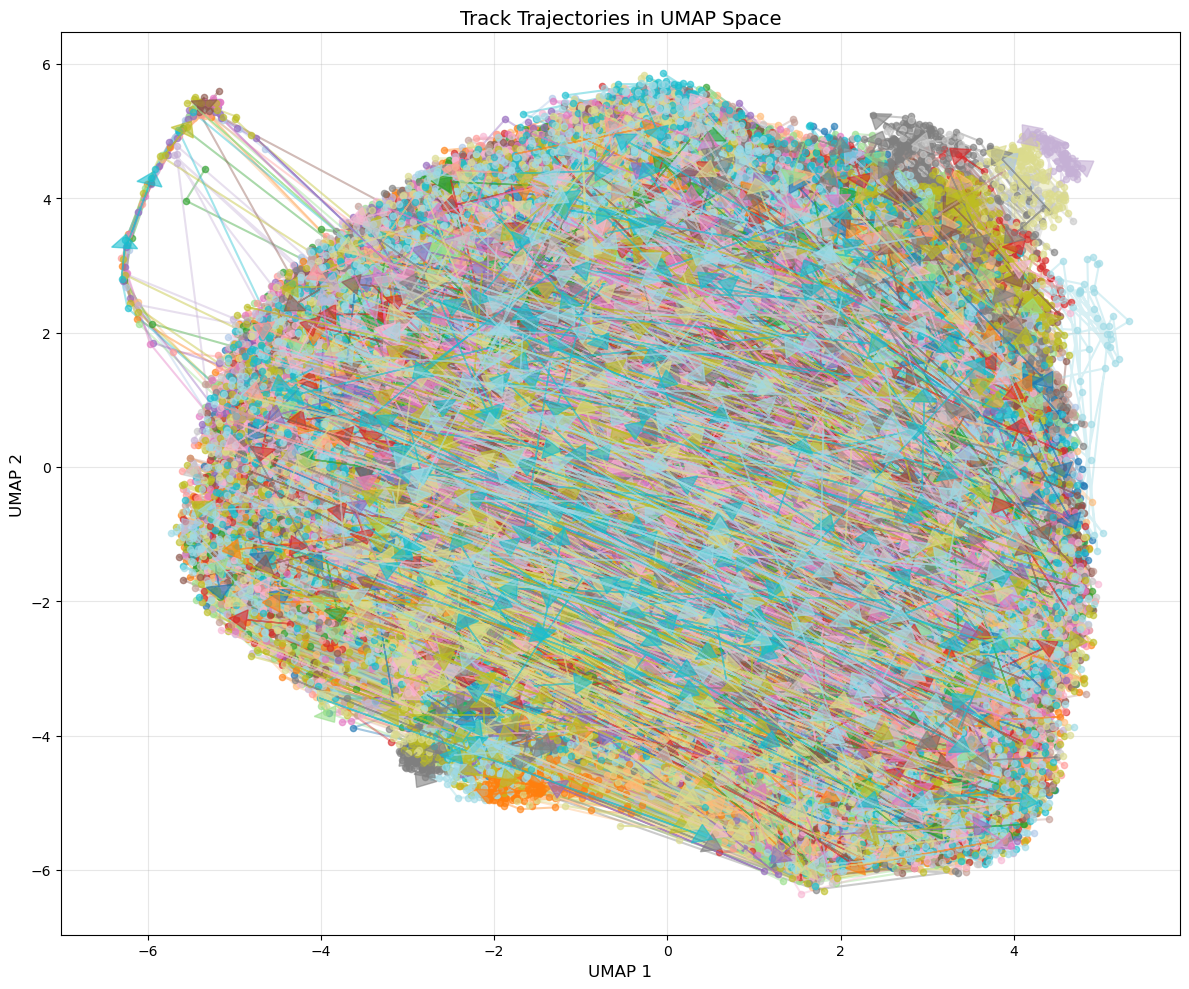

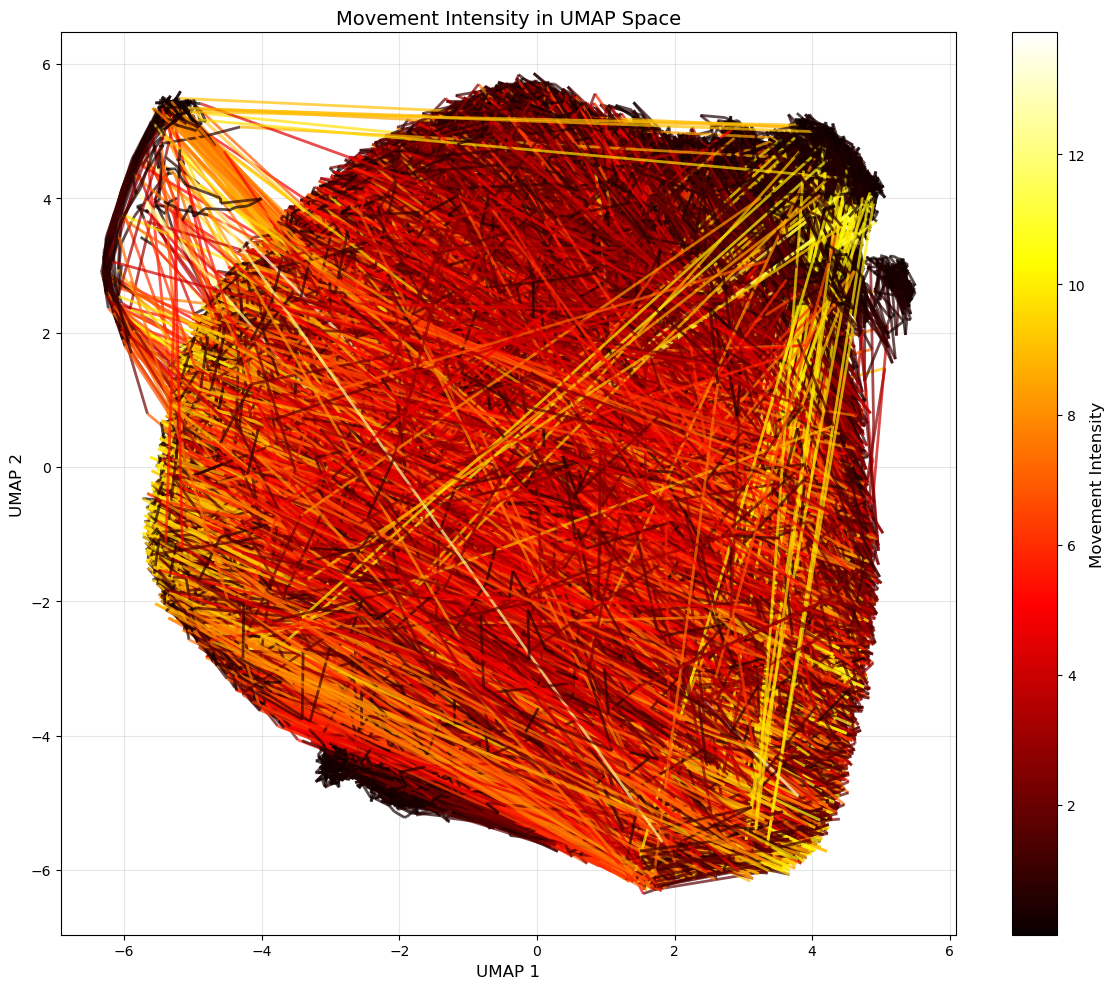

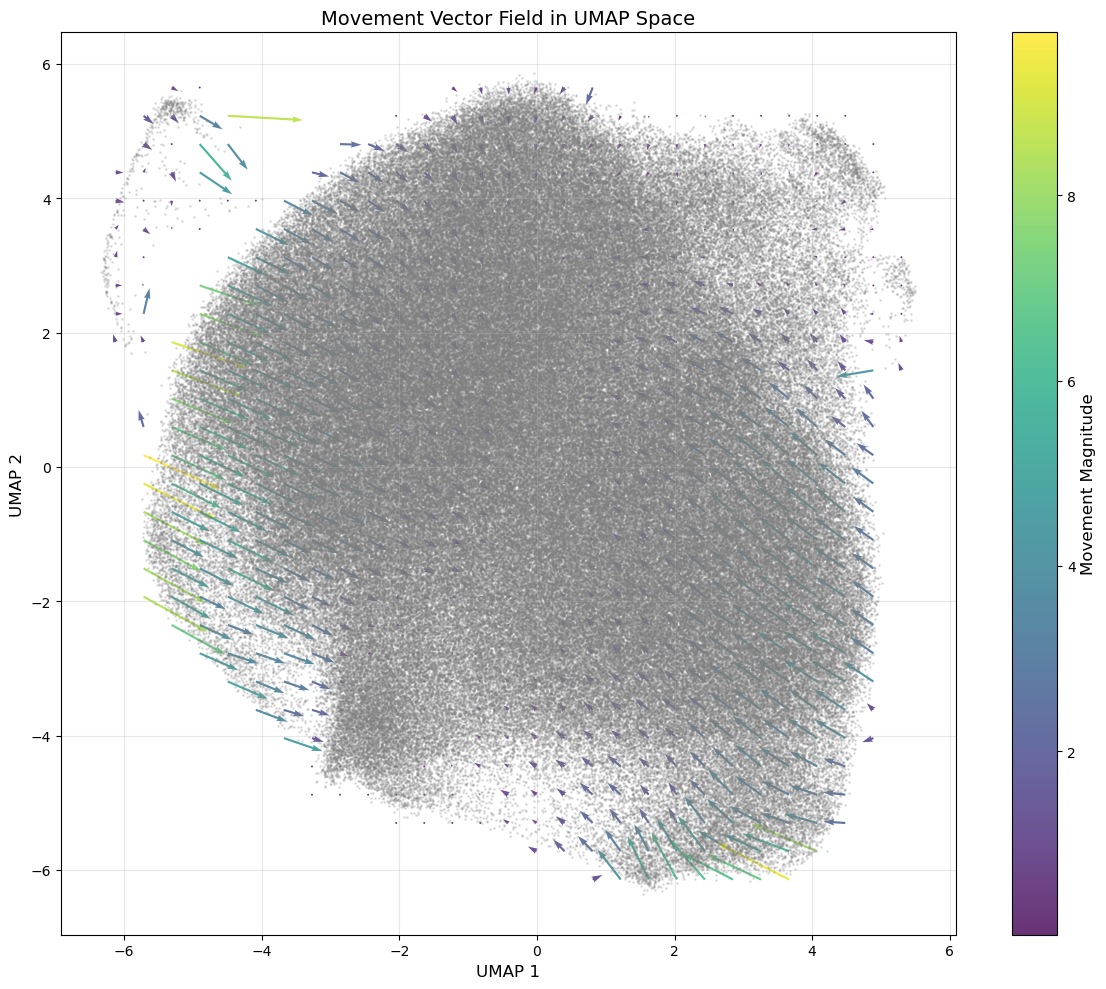

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_track_trajectories(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                            time_col='t', figsize=(12, 10), max_tracks=None,
                            show_arrows=True, show_points=True):
    """
    Plot UMAP with trajectories showing temporal connections within tracks.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Color map for tracks
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_tracks)))
    
    for track_idx, track_id in enumerate(unique_tracks):
        track_data = df[df[track_id_col] == track_id].copy()
        
        # Sort by time
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        # Plot points
        if show_points:
            ax.scatter(x, y, c=[colors[track_idx]], s=20, alpha=0.6, zorder=2)
        
        # Plot trajectory lines
        if len(x) > 1:
            ax.plot(x, y, c=colors[track_idx], alpha=0.4, linewidth=1.5, zorder=1)
            
            # Add arrows to show direction
            if show_arrows:
                for i in range(0, len(x)-1, max(1, len(x)//5)):  # Show ~5 arrows per track
                    dx = x[i+1] - x[i]
                    dy = y[i+1] - y[i]
                    ax.arrow(x[i], y[i], dx*0.8, dy*0.8, 
                            head_width=0.3, head_length=0.2,
                            fc=colors[track_idx], ec=colors[track_idx],
                            alpha=0.6, zorder=3)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Track Trajectories in UMAP Space', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_movement_intensity(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                            time_col='t', figsize=(12, 10)):
    """
    Visualize movement intensity (speed) along trajectories using color gradients.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    unique_tracks = df[track_id_col].unique()
    
    all_displacements = []
    
    # First pass: collect all displacements to get global min/max
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        displacements = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        all_displacements.extend(displacements)
    
    # Get global min/max for consistent coloring
    if len(all_displacements) > 0:
        vmin, vmax = np.min(all_displacements), np.max(all_displacements)
    else:
        vmin, vmax = 0, 1
    
    norm = plt.Normalize(vmin, vmax)
    
    # Second pass: plot with consistent coloring
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate movement intensity (displacement between consecutive points)
        displacements = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        
        # Create line segments with colors based on displacement
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap='hot', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(displacements)
        ax.add_collection(lc)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Movement Intensity', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Movement Intensity in UMAP Space', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_vector_field(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                     time_col='t', grid_size=20, figsize=(12, 10)):
    """
    Create a vector field showing dominant movement directions in different regions.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Collect all movements
    movements = []
    
    unique_tracks = df[track_id_col].unique()
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate movements
        for i in range(len(x) - 1):
            movements.append({
                'x': x[i],
                'y': y[i],
                'dx': x[i+1] - x[i],
                'dy': y[i+1] - y[i]
            })
    
    movements_df = pd.DataFrame(movements)
    
    # Create grid
    x_min, x_max = movements_df['x'].min(), movements_df['x'].max()
    y_min, y_max = movements_df['y'].min(), movements_df['y'].max()
    
    x_bins = np.linspace(x_min, x_max, grid_size)
    y_bins = np.linspace(y_min, y_max, grid_size)
    
    # Calculate average movement in each grid cell
    grid_x = []
    grid_y = []
    grid_dx = []
    grid_dy = []
    grid_intensity = []
    
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            mask = ((movements_df['x'] >= x_bins[i]) & 
                   (movements_df['x'] < x_bins[i+1]) &
                   (movements_df['y'] >= y_bins[j]) & 
                   (movements_df['y'] < y_bins[j+1]))
            
            if mask.sum() > 0:
                grid_x.append((x_bins[i] + x_bins[i+1]) / 2)
                grid_y.append((y_bins[j] + y_bins[j+1]) / 2)
                grid_dx.append(movements_df.loc[mask, 'dx'].mean())
                grid_dy.append(movements_df.loc[mask, 'dy'].mean())
                
                # Calculate intensity (magnitude)
                intensity = np.sqrt(grid_dx[-1]**2 + grid_dy[-1]**2)
                grid_intensity.append(intensity)
    
    grid_x = np.array(grid_x)
    grid_y = np.array(grid_y)
    grid_dx = np.array(grid_dx)
    grid_dy = np.array(grid_dy)
    grid_intensity = np.array(grid_intensity)
    
    # Plot vector field
    quiver = ax.quiver(grid_x, grid_y, grid_dx, grid_dy, grid_intensity,
                      cmap='viridis', scale=None, scale_units='xy',
                      angles='xy', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax)
    cbar.set_label('Movement Magnitude', fontsize=12)
    
    # Overlay scatter plot of all points
    all_x = movements_df['x'].values
    all_y = movements_df['y'].values
    ax.scatter(all_x, all_y, s=1, c='gray', alpha=0.2, zorder=1)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Movement Vector Field in UMAP Space', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example usage with your dataframe:
# 1. Basic trajectory plot (limit to 20 tracks for clarity)
plot_track_trajectories(df_emb_list, max_tracks=500)

# 2. Movement intensity visualization
plot_movement_intensity(df_emb_list)

# 3. Vector field showing dominant directions
plot_vector_field(df_emb_list, grid_size=30)

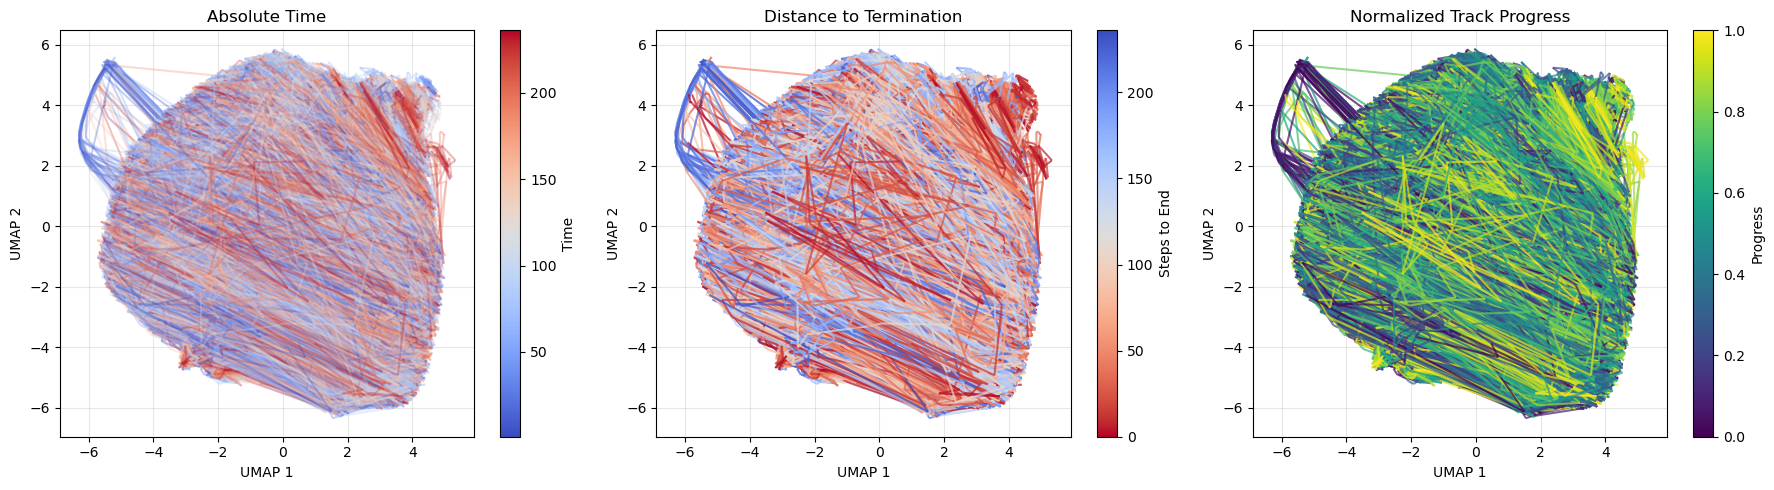

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
alpha = 0.1
def plot_trajectories_by_time(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                               time_col='t', figsize=(12, 10), max_tracks=None,
                               show_points=False):
    """
    Plot trajectories colored by time (early = blue, late = red).
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Get global time range for consistent coloring
    t_min = df[time_col].min()
    t_max = df[time_col].max()
    norm = plt.Normalize(t_min, t_max)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        t = track_data[time_col].values
        
        if len(x) < 2:
            continue
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use time values for coloring (average of segment endpoints)
        segment_times = (t[:-1] + t[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_times)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=t, cmap='coolwarm', norm=norm, s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Time (Blue=Early, Red=Late)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_trajectories_by_distance_to_end(df, umap_col=['umap_1', 'umap_2'], 
                                         track_id_col='track_id', time_col='t',
                                         figsize=(12, 10), max_tracks=None,
                                         show_points=False):
    """
    Plot trajectories colored by distance to termination (far = blue, near = red).
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Calculate max steps to termination across all tracks for normalization
    max_steps_to_term = 0
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        max_steps_to_term = max(max_steps_to_term, len(track_data))
    
    norm = plt.Normalize(0, max_steps_to_term)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate steps to termination for each point
        n_points = len(x)
        steps_to_term = np.arange(n_points, 0, -1)
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use steps to termination for coloring (average of segment endpoints)
        segment_steps = (steps_to_term[:-1] + steps_to_term[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm_r', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_steps)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=steps_to_term, cmap='coolwarm_r', norm=norm, 
                      s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Steps to Termination', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Distance to Termination (Blue=Far, Red=Near)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_trajectories_normalized_time(df, umap_col=['umap_1', 'umap_2'], 
                                      track_id_col='track_id', time_col='t',
                                      figsize=(12, 10), max_tracks=None,
                                      show_points=False):
    """
    Plot trajectories colored by normalized time within each track (0=start, 1=end).
    This is useful when tracks have different lengths.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    norm = plt.Normalize(0, 1)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Normalize time within track (0 to 1)
        n_points = len(x)
        normalized_time = np.linspace(0, 1, n_points)
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use normalized time for coloring
        segment_times = (normalized_time[:-1] + normalized_time[1:]) / 2
        
        lc = LineCollection(segments, cmap='viridis', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_times)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=normalized_time, cmap='viridis', norm=norm, 
                      s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Normalized Track Progress', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Normalized Time (Purple=Start, Yellow=End)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_all_temporal_views(df, umap_col=['umap_1', 'umap_2'], 
                            track_id_col='track_id', time_col='t',
                            max_tracks=50, figsize=(18, 5)):
    """
    Create a 3-panel figure showing all temporal coloring schemes.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Panel 1: Absolute time
    t_min = df[time_col].min()
    t_max = df[time_col].max()
    norm_time = plt.Normalize(t_min, t_max)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        t = track_data[time_col].values
        
        if len(x) < 2:
            continue
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_times = (t[:-1] + t[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm', norm=norm_time, alpha=0.3, linewidth=1.5)
        lc.set_array(segment_times)
        axes[0].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_time)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[0], label='Time')
    axes[0].set_title('Absolute Time')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].autoscale()
    axes[0].grid(True, alpha=0.3)
    
    # Panel 2: Distance to termination
    max_steps = 0
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        max_steps = max(max_steps, len(track_data))
    
    norm_steps = plt.Normalize(0, max_steps)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        n_points = len(x)
        steps_to_term = np.arange(n_points, 0, -1)
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_steps = (steps_to_term[:-1] + steps_to_term[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm_r', norm=norm_steps, alpha=0.7, linewidth=1.5)
        lc.set_array(segment_steps)
        axes[1].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm_steps)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[1], label='Steps to End')
    axes[1].set_title('Distance to Termination')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].autoscale()
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Normalized time
    norm_norm = plt.Normalize(0, 1)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        n_points = len(x)
        normalized_time = np.linspace(0, 1, n_points)
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_times = (normalized_time[:-1] + normalized_time[1:]) / 2
        
        lc = LineCollection(segments, cmap='viridis', norm=norm_norm, alpha=0.7, linewidth=1.5)
        lc.set_array(segment_times)
        axes[2].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm_norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[2], label='Progress')
    axes[2].set_title('Normalized Track Progress')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].autoscale()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Example usage:

# Individual plots
#plot_trajectories_by_time(df_emb_list, max_tracks=50)
#plot_trajectories_by_distance_to_end(df_emb_list, max_tracks=50)
#plot_trajectories_normalized_time(df_emb_list, max_tracks=50)

# All three in one figure for comparison
plot_all_temporal_views(df_emb_list, max_tracks=1000)

In [31]:
df_emb_list

track_id    t    y    x  \
0            194  232  714  790   
1           2308  115  736  812   
2           2982  204  572   72   
3           1726   69  334  586   
4            447    9  936  294   
...          ...  ...  ...  ...   
390349      1618   83  296  414   
390350        15   35  676  832   
390351       922  123  184  858   
390352       922  207  190  860   
390353       938  197  124  702   

                                                embedding  \
0       [-5.613732338, -0.9868487716000001, -0.3235633...   
1       [-2.4552211761000002, 0.0558483228, 0.35831421...   
2       [-2.5747191905999998, -0.6678379774000001, -1....   
3       [-4.7323694229, -4.4051270485, 0.8342545033000...   
4       [-5.4849886894, 0.3814259171, -1.4526306391000...   
...                                                   ...   
390349  [1.5921068192, -5.4840259552, 1.7566857338, 3....   
390350  [-1.5060194731, -4.9115228653, -2.0324203968, ...   
390351  [-4.6128573418, -0.0126014696, 1.5435472727000...   
390352  [-1.9490828514, 0.9688180089, 0.7358534336, -5...   
390353  [0.482606709, -0.5701556802000001, -0.12362045...   

                                                     path      filename  \
0       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
1       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
2       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
3       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
4       /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
...                                                   ...           ...   
390349  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390350  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390351  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390352  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   
390353  /mnt/imaging.data/nbahou/apoDet_refactored/dat...  Exp06_Site37   

       phenotype  t_apoptosis    umap_1    umap_2 label_manual  
0        non-apo          NaN  4.057728 -1.997006         None  
1        non-apo          NaN  0.353653  0.797747         None  
2        non-apo          NaN  2.645425  0.312282         None  
3        non-apo          NaN -1.505062  1.078035         None  
4        non-apo          NaN -1.013970 -1.243709         None  
...          ...          ...       ...       ...          ...  
390349       apo         79.0 -5.402977  3.766285         None  
390350       apo          9.0 -5.490371  4.768259         None  
390351       apo         62.0  4.597286  4.336355         None  
390352       apo         62.0  4.594141  4.188517         None  
390353       apo        183.0  4.245855  4.635402         None  

[390354 rows x 12 columns]